# Tutorial 5: A Bayesian Inverse Problem - Inferring Ice Melt from Tide Gauges

In our previous tutorials, we have focused on the **forward problem**: predicting the Earth's response to a *known* change in ice mass. In this tutorial, we will tackle the more challenging **inverse problem**: inferring an *unknown* ice mass change from a set of sparse and noisy observations.

We will use the full power of the `pyslfp` and `pygeoinf` libraries to solve this problem within a **Bayesian framework**. Instead of finding a single "best-fit" solution, the Bayesian method provides a full **posterior probability distribution**. From this, we can extract the **posterior expectation**, which represents our most likely estimate of the ice melt pattern. The full posterior distribution also characterises the uncertainty in our knowledge about the ice mass change. Methods in `pygeoinf` exist for working practically with the full posterior distribution though there computational cost remains rather high. Here, instead we will use the full posterior distribution to estimate the uncertainty in a small number of quantities of particular physical interest. 

Our goal:
> Given sea-level measurements from the **Global Sea Level Observing System (GLOSS)** tide gauge network, what can we infer about the global pattern of ice thickness change that produced them?

## Setup

We begin by importing the necessary components from `pyslfp`, `pygeoinf`, and other standard libraries. We will also initialize our `FingerPrint` model, which provides the underlying physics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pyslfp as sl
import pygeoinf as inf
import cartopy.crs as ccrs

# Initialize the core fingerprint model
fp = sl.FingerPrint(
    lmax=128,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp.set_state_from_ice_ng()

## Step 1: Loading the Tide Gauge Data

We will use the real locations from the GLOSS tide gauge network. The `read_gloss_tide_gauge_data` function in our `utils` module handles loading this data for us.

All of the listed stations can be used, or a random sub-sample can be chosen. 

In [2]:
# Load the full list of GLOSS tide gauge stations
names, lats, lons = sl.read_gloss_tide_gauge_data()

# --- Configuration for data selection ---
use_all_stations = True
number_of_stations_to_sample = 30

# -----------------------------------------
if use_all_stations:
    tide_gauge_points = list(zip(lats, lons))
else:
    # Create a reproducible random sample of stations
    random.seed(123)
    indices = random.sample(range(len(names)), number_of_stations_to_sample)
    sampled_lats = [lats[i] for i in indices]
    sampled_lons = [lons[i] for i in indices]
    tide_gauge_points = list(zip(sampled_lats, sampled_lons))

print(f"Using {len(tide_gauge_points)} tide gauge stations for the inversion.")

Using 75 tide gauge stations for the inversion.


## Step 2: Defining the Model Space

The next step is to define the space of possible solutions. Our unknown is the global pattern of **ice thickness change**. We will model this as a smooth, continuous field on the surface of the sphere.

A `pygeoinf.symmetric_space.sphere.Sobolev` space is the perfect choice for this. It's a function space that contains spatially smooth fields. We will give it a smoothness `order=2` and a characteristic `scale` of 100 km. These values can be changed to examine their role in solving the inverse problem. 

In [3]:
# Define the model space for the unknown ice thickness change
order = 2.0
scale_km = 500.0
scale = scale_km * 1000 / fp.length_scale

model_space = inf.symmetric_space.sphere.Sobolev(
    fp.lmax, order, scale, radius=fp.mean_sea_floor_radius
)

## Step 3: Defining the Forward Operator

Next, we must define the **forward operator**. This is the mathematical object that represents the complete chain of physical processes and measurements linking our model (ice thickness change) to our data (tide gauge readings).

Using the operator algebra of `pygeoinf`, we can build this complex chain by composing several simpler operators:

1.  **`ice_projection_operator`**: Takes a scalar-field defined everywhere on the surface and multiplied by a function equal to one over the current ice sheets. 
2.  **`ice_thickness_change_to_load_operator`**: Takes an ice thickness change field and converts it to a surface mass load.
3.  **`fp.as_sobolev_linear_operator`**: The main fingerprint operator. It takes the mass load and calculates the full physical response: `[sea-level, displacement, gravity, rotation]`.
4.  **`tide_gauge_operator`**: This takes the full response and evaluates the sea level change at the discrete locations of our tide gauges.

The final forward operator, `A`, is the composition of all three steps.

In [4]:

# Maps scalar-fields on sphere to be non-zero only over background ice sheets. 
op1 = sl.ice_projection_operator(fp, model_space)

# Maps an ice thickness change to the corresponding load. 
op2 = sl.ice_thickness_change_to_load_operator(fp, model_space)

# Maps a direct load to the full response. 
op3 = fp.as_sobolev_linear_operator(order, scale)

# Maps the full response to the tide gauge values. 
op4 = sl.operators.tide_gauge_operator(op3.codomain, tide_gauge_points)

# Form the forward operator by composition. 
A = op4@ op3 @ op2 @ op1
data_space = A.codomain

# Form also a mapping from the model space to the sea level field for convenience. 
P = op3.codomain.subspace_projection(0)
A_sl = P @ op3 @ op2 @ op1

## Step 4: Setting up the LinearForwardProblem

Now we bundle the forward operator `A` with a model for our measurement errors. We'll assume the tide gauge measurements are corrupted by random, uncorrelated Gaussian noise with a standard deviation of 1 mm.

The `pygeoinf.LinearForwardProblem` class encapsulates this entire structure: **data = A(model) + error**.

In [5]:
# Define the data error statistics
tide_gauge_std_dev_m = 0.001
tide_gauge_std_dev = tide_gauge_std_dev_m / fp.length_scale
data_error_measure = inf.GaussianMeasure.from_standard_deviation(
    data_space, tide_gauge_std_dev
)

# Bundle everything into a forward problem object
forward_problem = inf.LinearForwardProblem(
    A, data_error_measure=data_error_measure
)

## Step 5: Creating a Synthetic Reality

To test our inversion, we need a "ground truth" to compare our results against. We will create a synthetic reality by first generating a plausible "true" ice melt scenario.

We do this by defining a **prior probability distribution** on the model space. This "prior" represents our beliefs about the ice thickness change *before* seeing any data. We'll use a smooth, zero-mean Gaussian measure.

We then draw one random sample from this prior to be our `model_true`. Finally, we generate the `data` that this true model would produce by applying the forward operator and adding random noise.


In [6]:
# Set the initial model prior measure
pointwise_std_m = 0.05
pointwise_std = pointwise_std_m / fp.length_scale
initial_model_prior_measure = model_space.point_value_scaled_heat_kernel_gaussian_measure(scale, pointwise_std)

# Transform so that ice thickness change non-zero only over current ice sheets. 
model_prior_measure = initial_model_prior_measure.affine_mapping(operator=op1)

# --- Generate the synthetic ground truth and noisy data ---
model_true, data = forward_problem.synthetic_model_and_data(model_prior_measure)

### Visualizing the "True" Sea-Level Field

Before we solve the inverse problem, let's visualize the continuous sea-level fingerprint that corresponds to our `model_true`. This is the underlying signal that our sparse network of tide gauges is sampling. Plotting this helps to understand the challenge of the inverse problem and provides a visual reference for the magnitude of the data errors.

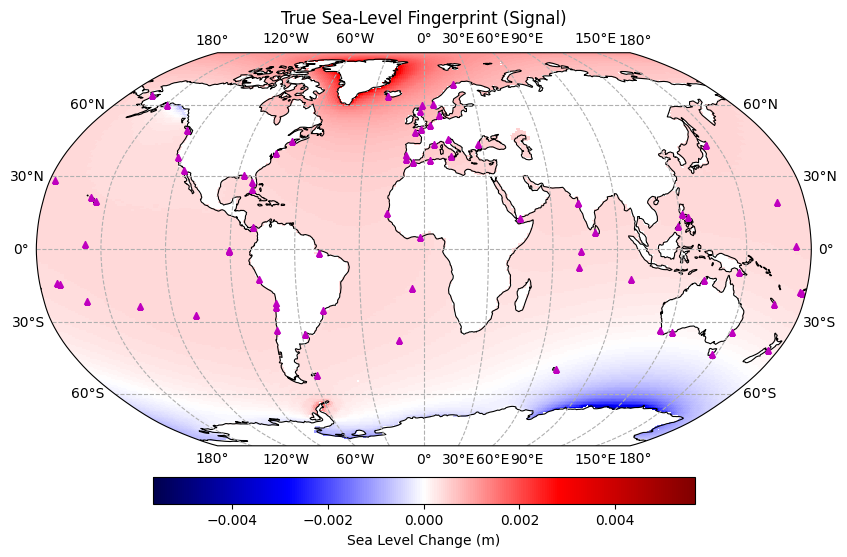

In [7]:
# Calculate the true sea-level field from the true ice model
sea_level_true = A_sl(model_true)

# Plot the true sea-level fingerprint -- note the redimensionalisation. 
fig, ax, im = sl.plot(
    sea_level_true * fp.ocean_projection() * fp.length_scale,
    coasts=True,
    cmap="seismic",
    symmetric=True
)
ax.set_title("True Sea-Level Fingerprint (Signal)")

# Overlay the tide gauge locations to show what is being sampled
lats = [p[0] for p in tide_gauge_points]
lons = [p[1] for p in tide_gauge_points]
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())

fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

## Step 6: Solving the Bayesian Inverse Problem

Now we have all the ingredients to solve the inverse problem. We use the `pygeoinf.LinearBayesianInversion` class, providing it with our forward problem and our prior.

The `model_posterior_measure` method applies Bayes' theorem to combine the prior information with the information from the data. The result is the **posterior probability distribution**, which represents our updated, combined state of knowledge.

In determining the posterior distribution, the expected value is calcuated explicitly, this requiring inversion of a linear system with size equal to the data space. The posterior covariance, however, is lazily evaluated, meaning that it is present as a LinearOperator whose action can be called, but in determining this action it is necessary to solve for a different right hand side the linear system on the data space. Later, when we push forward the posterior measure to low-dimensional property spaces, a handful of further solutions of this linear system will be needed to determine the resulting covariance matrices in concrete terms.

In [8]:
# Set up the Bayesian inversion method
bayesian_inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Solve for the posterior distribution
model_posterior_measure = bayesian_inversion.model_posterior_measure(
    data, inf.CGMatrixSolver()
)

# Get the posterior expectation
model_posterior_expectation = model_posterior_measure.expectation

## Step 7: Analyzing and Visualizing the Result

The primary result we are interested in is the **posterior expectation**. This is our best estimate of the true ice thickness change, given our prior beliefs and the information contained in the tide gauge data.

The full posterior distribution also contains the **posterior covariance**, which quantifies our uncertainty. For this tutorial, we will focus solely on the posterior expectation.

### Plotting the Inferred Ice Melt

First, we will create two separate plots to compare the "ground truth" ice melt with our inferred result:
1.  **The True Model:** The actual ice thickness change we were trying to recover.
2.  **The Posterior Expectation:** Our best estimate, which we hope resembles the true model.

To ensure a fair visual comparison, we will calculate a common color scale based on the maximum absolute value across both fields.

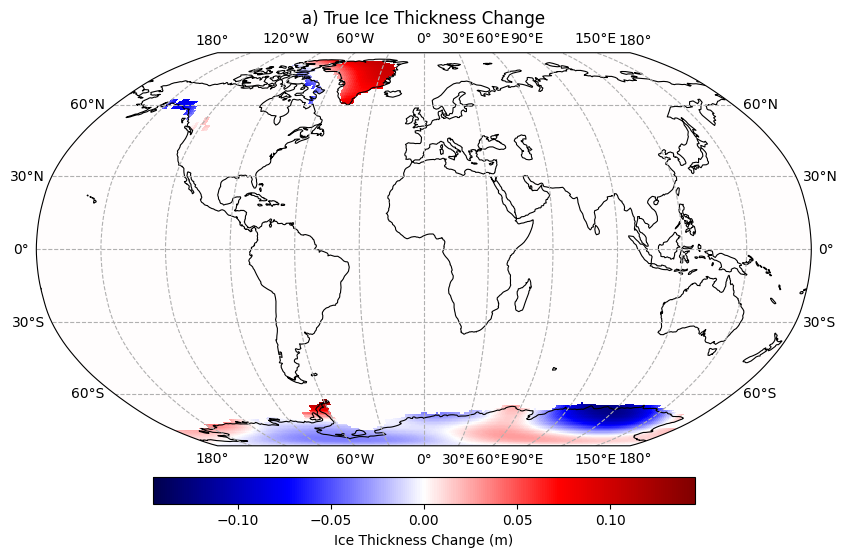

In [9]:
# --- Calculate a shared, symmetric color scale for the ice thickness plots ---
# We mask with the ice projection to avoid including NaNs in the calculation
ice_mask = fp.ice_projection(0)
max_abs_ice_change = np.nanmax(
    np.abs(
        np.concatenate([
            (model_true * ice_mask).data.flatten(),
            (model_posterior_expectation * ice_mask).data.flatten()
        ])
    )
) * fp.length_scale

# --- Plot 1: The "Ground Truth" Model ---
fig, ax, im = sl.plot(
    model_true * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_ice_change,
    vmax=max_abs_ice_change
)
ax.set_title("a) True Ice Thickness Change")
fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Ice Thickness Change (m)")
plt.show()

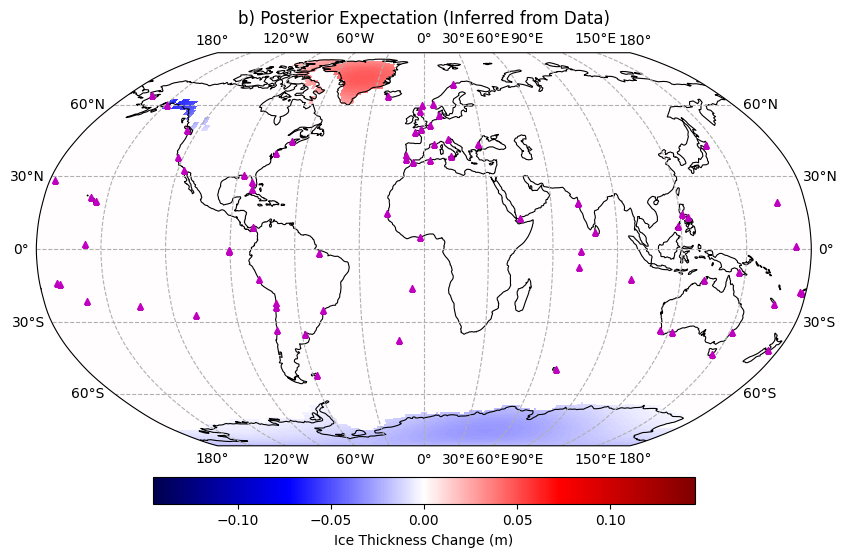

In [10]:
# --- Plot 2: The Posterior Expectation (Our Best Estimate) ---
fig, ax, im = sl.plot(
    model_posterior_expectation  * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_ice_change,
    vmax=max_abs_ice_change
)
ax.set_title("b) Posterior Expectation (Inferred from Data)")

# Mark the tide gauge locations
lats = [p[0] for p in tide_gauge_points]
lons = [p[1] for p in tide_gauge_points]
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())

fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Ice Thickness Change (m)")
plt.show()

### Plotting the Predicted Sea Level

As a final check, we can use our inferred ice melt pattern (`model_posterior_expectation`) to predict the global sea-level fingerprint. By comparing this predicted fingerprint to the "true" fingerprint, we can visually assess how well our inversion has captured the large-scale signal.

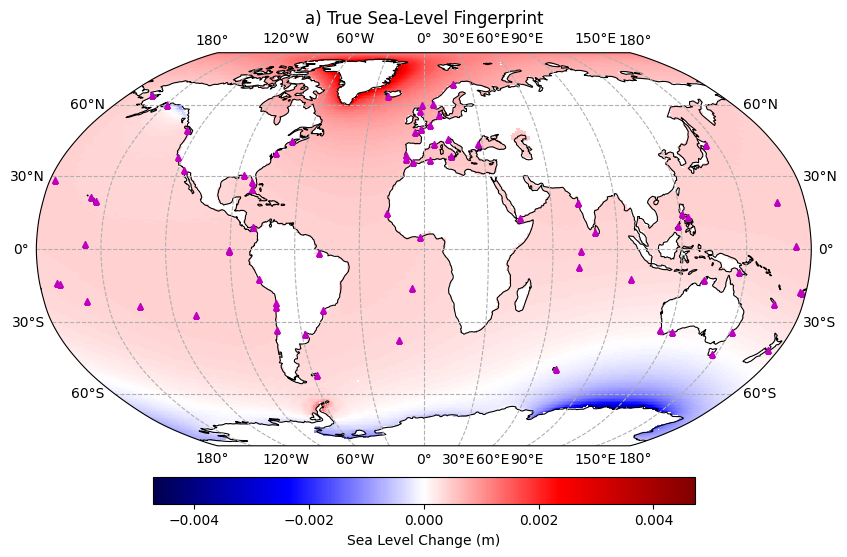

In [11]:

# Calculate the predicted sea-level field from the posterior expectation model
sea_level_posterior = A_sl(model_posterior_expectation)

# --- Calculate a shared, symmetric color scale for the sea-level plots ---
ocean_mask = fp.ocean_projection()
max_abs_sl_change = np.nanmax(
    np.abs(
        np.concatenate([
            (sea_level_true * ocean_mask).data.flatten(),
            (sea_level_posterior * ocean_mask).data.flatten()
        ])
    )
) * fp.length_scale


# --- Plot 3: The "True" Sea-Level Field ---
fig, ax, im = sl.plot(
    sea_level_true * ocean_mask * fp.length_scale,    
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax.set_title("a) True Sea-Level Fingerprint")
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

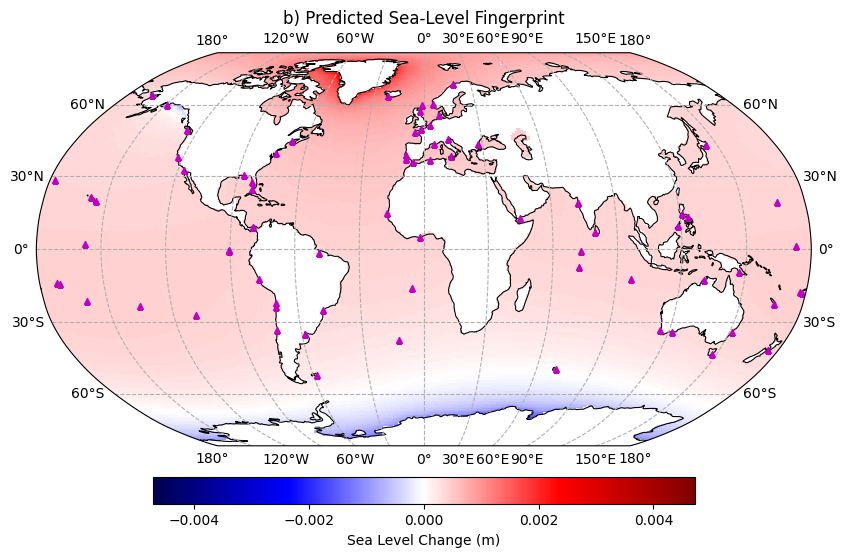

In [12]:
# --- Plot 4: The Sea-Level Field Predicted by the Inversion ---
fig, ax, im = sl.plot(
    sea_level_posterior * fp.ocean_projection()* fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax.set_title("b) Predicted Sea-Level Fingerprint")
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

## Mapping the posterior onto a lower-dimensional space

Comparison of the true and posterior mean ice thickness changes suggests that while the tide gauge data can recover broadly correct features of the ice thickness change, it is not possible to recover fine spatial details. This is not surprising given the relative sparsity of the data and the fact that most tide gauges are located far from the polar regions. 

Despite this limitation, we can still investigate the extent to which certain average properties of the ice thickness change can be determined. First, we look at the estimated global mean sea level (GMSL) change. To do so, we set up, via a simple mass balance, a LinearOperator from the model space to resulting 1D property space. The model posterior measure can be pushed forward under this mapping, and we can then visualise the resulting distribution. 

In a near identical manner, we can look at estimates for contributions from the northern and southern hemispheres separately. 

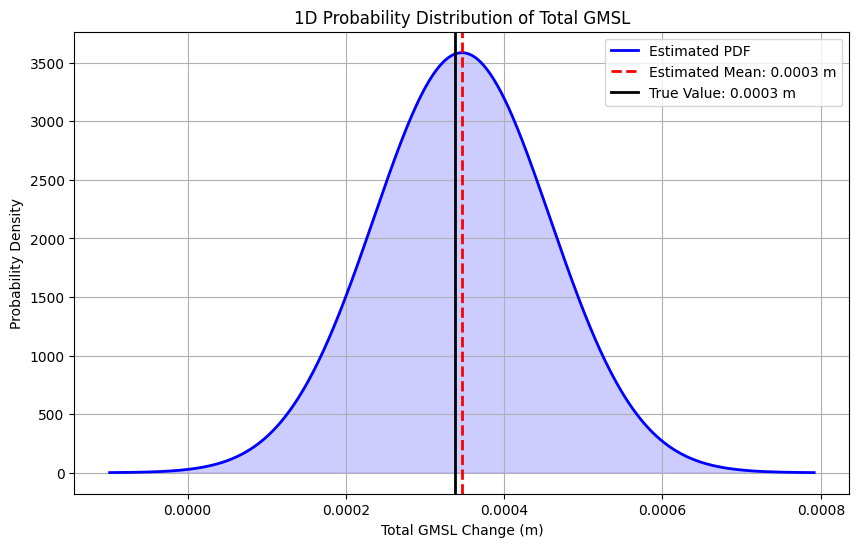

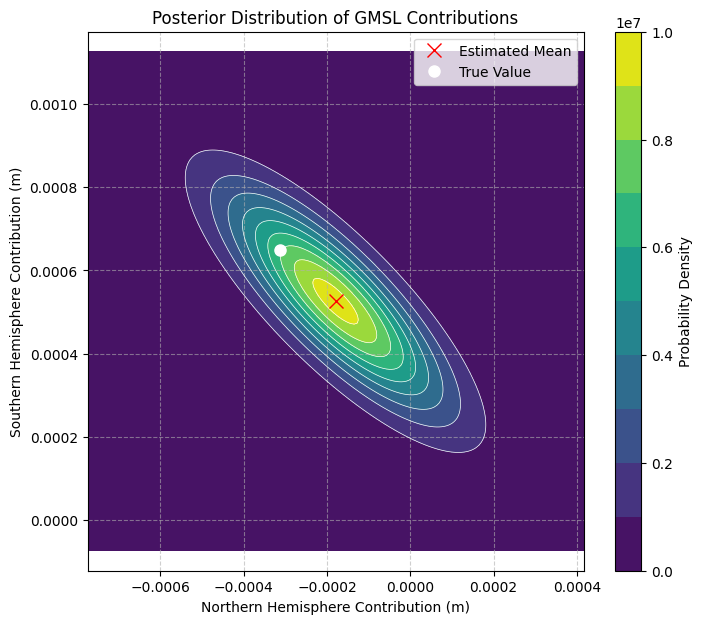

In [13]:
# Set the weighting function for GMSL estimates  - Note that length scale factor to dimensionalise the result.
GMSL_weighting_function =  -fp.ice_density * fp.one_minus_ocean_function * fp.ice_projection(0) * fp.length_scale / (fp.water_density * fp.ocean_area)

# Set weigthing functions for northern and southern hemisphere contributions
GMSL_weighting_function_northern =  GMSL_weighting_function * fp.northern_hemisphere_projection(0)
GMSL_weighting_function_southern =  GMSL_weighting_function * fp.southern_hemisphere_projection(0)

# Form the mapping to GSML. 
B = sl.averaging_operator(model_space, [GMSL_weighting_function])

# Form the mapping to northern and southern hemisphere contributions to GSML. 
C = sl.averaging_operator(model_space, [GMSL_weighting_function_northern, GMSL_weighting_function_southern])

# Get the true values. 
GMSL_true = B(model_true)
GMSL_northern_true, GMSL_southern_true = C(model_true)

# Push forward the posterior to the GMSL space.
GMSL_posterior_measure = model_posterior_measure.affine_mapping(operator=B)

# Get the measure as a scipy distribution. 
GMSL_distribution = GMSL_posterior_measure.as_multivariate_normal()


# Plot the PDF for GMSL. 
gmsl_mean = GMSL_distribution.mean[0]
gmsl_std = np.sqrt(GMSL_distribution.cov[0, 0])
x_axis = np.linspace(gmsl_mean - 4 * gmsl_std, gmsl_mean + 4 * gmsl_std, 400)
pdf_values = GMSL_distribution.pdf(x_axis)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, pdf_values, color='blue', lw=2, label='Estimated PDF')
plt.fill_between(x_axis, pdf_values, color='blue', alpha=0.2)
plt.axvline(gmsl_mean, color='red', linestyle='--', lw=2, label=f'Estimated Mean: {gmsl_mean:.4f} m')
plt.axvline(GMSL_true[0], color='black', linestyle='-', lw=2, label=f'True Value: {GMSL_true[0]:.4f} m')
plt.title('1D Probability Distribution of Total GMSL')
plt.xlabel('Total GMSL Change (m)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# Now push forward to the 2D property space. 
GMSL_hemisphere_posterior_measure =  model_posterior_measure.affine_mapping(operator=C)

# Contour plot the pdf. 
property_distribution = GMSL_hemisphere_posterior_measure.as_multivariate_normal()
mean = property_distribution.mean
cov = property_distribution.cov
std_devs = np.sqrt(np.diag(cov))
x = np.linspace(mean[0] - 3.5 * std_devs[0], mean[0] + 3.5 * std_devs[0], 200)
y = np.linspace(mean[1] - 3.5 * std_devs[1], mean[1] + 3.5 * std_devs[1], 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = property_distribution.pdf(pos)
plt.figure(figsize=(8, 7))
contour = plt.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)
cbar = plt.colorbar(contour)
cbar.set_label('Probability Density')
plt.plot(mean[0], mean[1], 'rx', markersize=10, label='Estimated Mean')
plt.plot(GMSL_northern_true, GMSL_southern_true, 'wo', markersize=8, label='True Value')
plt.title('Posterior Distribution of GMSL Contributions')
plt.xlabel('Northern Hemisphere Contribution (m)')
plt.ylabel('Southern Hemisphere Contribution (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()


## Conclusion

In this tutorial, we have successfully performed a Bayesian inversion to infer a global ice melt pattern from sparse, noisy data from the GLOSS tide gauge network.

The results show that:
* The **posterior expectation** for ice melt successfully recovers the large-scale features of the **true model**, even though it was derived from only a small number of global tide gauges.
* The **predicted sea-level fingerprint** from our inversion result is a good match for the true fingerprint, demonstrating that our solution is consistent with the physics of the problem.
* The estimates for GMSL change are quite accurate, with our results also providing rigorous uncertainties subject to our choice of prior. 
* There is a strong trade-off seen between northern and southern hemisphere contributions to GMSL, and hence it is difficult from this data to untangle their relative importance. 

